<a href="https://colab.research.google.com/github/IammHardy/DPRO-ASSIGNMENT/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import pandas as pd
import keras
import os

from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
# Import plot_model from the correct module in TensorFlow 2.0+
from tensorflow.keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

from tqdm import tqdm_notebook

<ipython-input-13-3427b3f9d463>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [14]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res

def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

In [15]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [16]:
train_df = pd.read_csv("../content/drive/MyDrive/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../content/drive/MyDrive/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

In [18]:
train_df["images"] = [
    np.array(load_img("/content/drive/MyDrive/train/images/{}.png".format(idx), grayscale=True)) / 255
    if os.path.exists("/content/drive/MyDrive/train/images/{}.png".format(idx))
    else None # Handle the case where the file doesn't exist
    for idx in tqdm_notebook(train_df.index)
]

<ipython-input-18-80fafbf18199>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(train_df.index)


  0%|          | 0/4000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [20]:
train_df["masks"] = [
    np.array(load_img("/content/drive/MyDrive/train/masks/{}.png".format(idx), grayscale=True)) / 255
    if os.path.exists("/content/drive/MyDrive/train/masks/{}.png".format(idx))
    else None # Handle cases where the file doesn't exist
    for idx in tqdm_notebook(train_df.index)
]

<ipython-input-20-f8da2db07291>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(train_df.index)


  0%|          | 0/4000 [00:00<?, ?it/s]

In [21]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [22]:
def cov_to_class(val):
    for i in range(0, 11):
        if val * 10 <= i :
            return i

train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

<ipython-input-23-965efe28fc17>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df.coverage, kde=False, ax=axs[0])
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2464: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-23-965efe28fc17>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility

Text(0.5, 0, 'Coverage class')

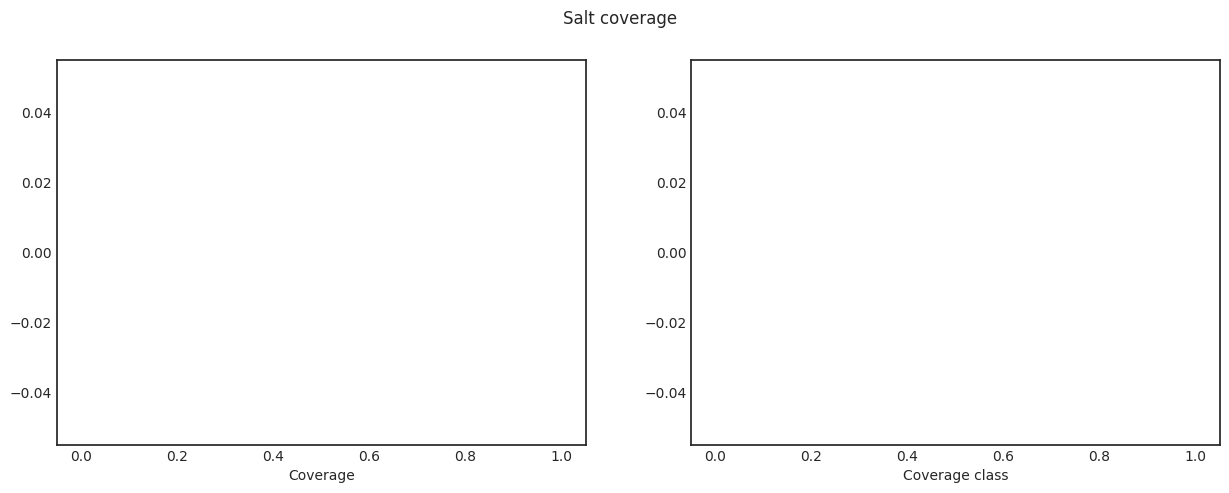

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

Text(0, 0.5, 'Coverage class')

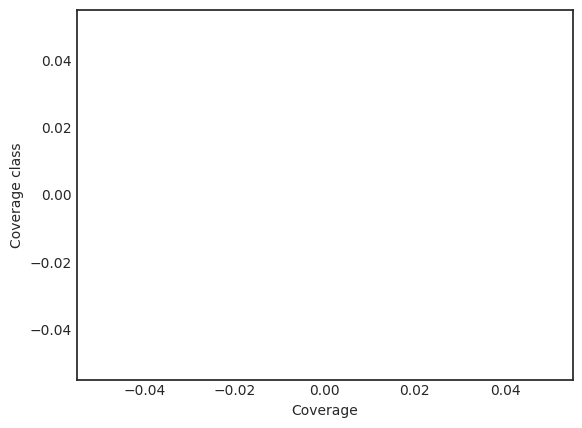

In [24]:
plt.scatter(train_df.coverage, train_df.coverage_class)
plt.xlabel("Coverage")
plt.ylabel("Coverage class")

<ipython-input-25-95ccac4bf754>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df.z, label="Train")
<ipython-input-25-95ccac4bf754>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_df.z, label="Test")


Text(0.5, 1.0, 'Depth distribution')

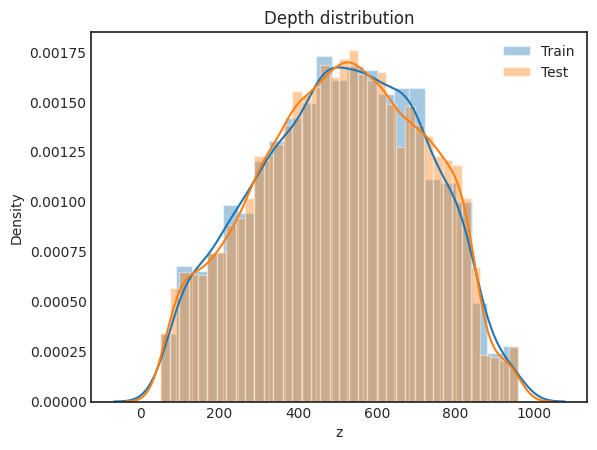

In [25]:
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

TypeError: Image data of dtype object cannot be converted to float

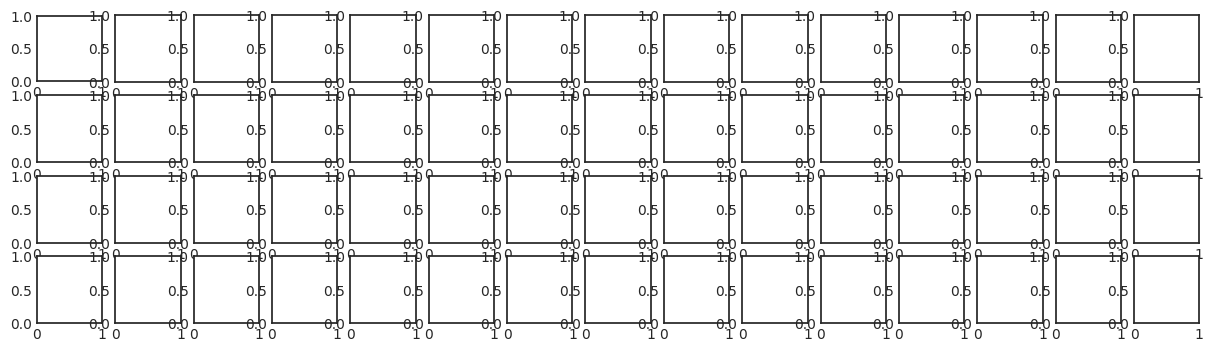

In [35]:
import matplotlib.pyplot as plt

max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)

# Assuming img_size_ori is defined somewhere
img_size_ori = 256  # Example value, adjust as per your image size

fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx, 'images']  # Assuming 'images' is the column name for images
    mask = train_df.loc[idx, 'masks']  # Assuming 'masks' is the column name for masks

    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")

    # Example text positions, adjust as needed
    ax.text(10, 10, f"Depth: {train_df.loc[idx, 'z']}", color="black")
    ax.text(img_size_ori - 10, 10, f"Coverage: {round(train_df.loc[idx, 'coverage'], 2)}", color="black", ha="right", va="top")
    ax.text(10, img_size_ori - 10, f"Coverage Class: {train_df.loc[idx, 'coverage_class']}", color="black", ha="left", va="top")

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Index: {idx}")  # Set title as per your requirement

plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")
plt.tight_layout()
plt.show()


In [44]:
import matplotlib.pyplot as plt
from skimage.transform import resize
import numpy as np

def upsample(img):
    if img is None:  # Handle the case where img is None
        return np.zeros((img_size_target, img_size_target), dtype=np.uint8)  # Return a black image or handle as needed
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)

# Handle None values in 'coverage_class' before splitting
train_df.coverage_class.fillna(-1, inplace=True)  # Replace None with -1 or any suitable value

ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1),
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1),
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1337)
# ... (rest of your code)

In [45]:
def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    #uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)

    return output_layer

input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16)

In [46]:
model = Model(input_layer, output_layer)

In [48]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 128, 128, 16)         160       ['input_2[0][0]']             
                                                                                                  
 conv2d_20 (Conv2D)          (None, 128, 128, 16)         2320      ['conv2d_19[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 16)           0         ['conv2d_20[0][0]']           
 g2D)                                                                                       

In [49]:
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

Text(0.5, 0.98, 'Top row: original images, bottom row: augmented images')

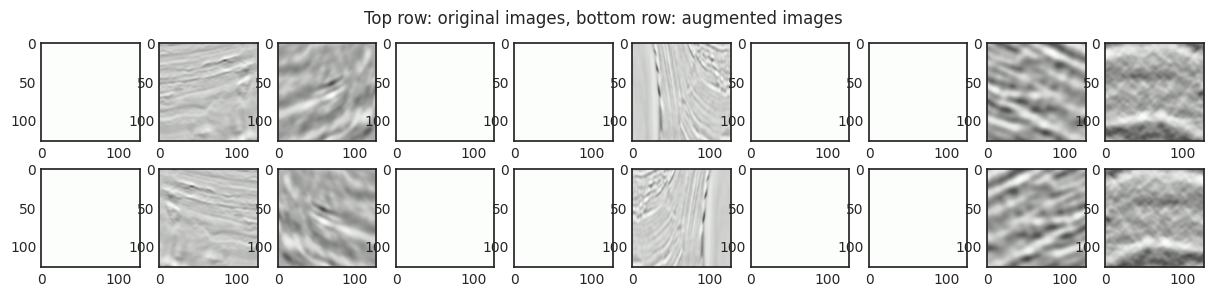

In [50]:
fig, axs = plt.subplots(2, 10, figsize=(15,3))
for i in range(10):
    axs[0][i].imshow(x_train[i].squeeze(), cmap="Greys")
    axs[0][i].imshow(y_train[i].squeeze(), cmap="Greens", alpha=0.3)
    axs[1][i].imshow(x_train[int(len(x_train)/2 + i)].squeeze(), cmap="Greys")
    axs[1][i].imshow(y_train[int(len(y_train)/2 + i)].squeeze(), cmap="Greens", alpha=0.3)
fig.suptitle("Top row: original images, bottom row: augmented images")

In [53]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

epochs = 5
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid],
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Epoch 1/5
200/200 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1: val_loss improved from inf to 0.00000, saving model to ./keras.model
200/200 [==============================] - 75s 376ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/5
200/200 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2: val_loss did not improve from 0.00000
200/200 [==============================] - 19s 95ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/5
200/200 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3: val_loss did not improve from 0.00000
200/200 [==============================] - 19s 94ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/5
200/200 [==============================] - ETA: 0s - loss:

Epoch 1/5
200/200 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1: val_loss did not improve from 0.00000
200/200 [==============================] - 26s 95ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/5
200/200 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2: val_loss did not improve from 0.00000
200/200 [==============================] - 18s 92ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/5
200/200 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3: val_loss did not improve from 0.00000
200/200 [==============================] - 19s 94ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/5
200/200 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
E

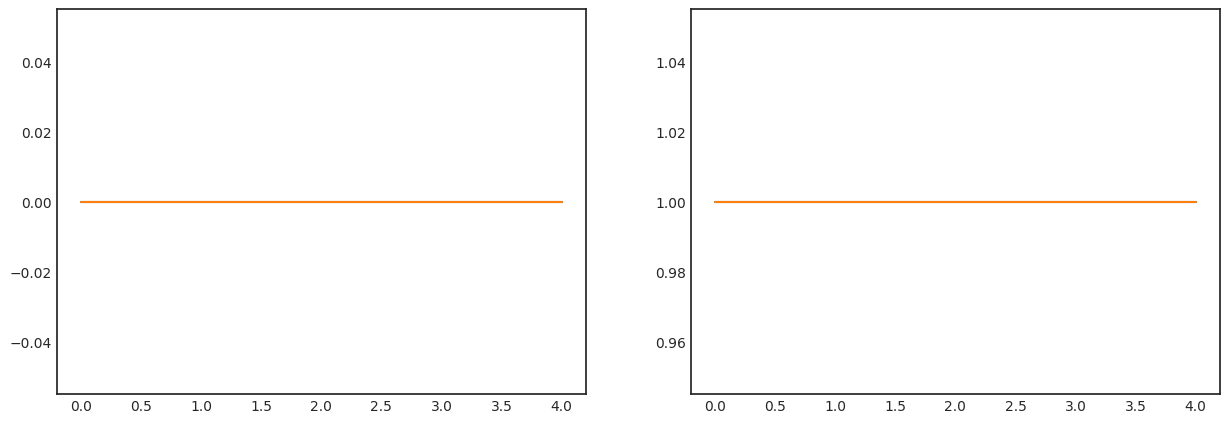

In [55]:
# Add accuracy to the metrics list when compiling the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Now, retrain the model and plot the results
history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid],
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["accuracy"], label="Train accuracy") # Access accuracy with 'accuracy' key
ax_acc.plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")

In [56]:
model = load_model("./keras.model")

In [57]:
preds_valid = model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.array([train_df.loc[idx].masks for idx in ids_valid])

25/25 [==============================] - 1s 22ms/step


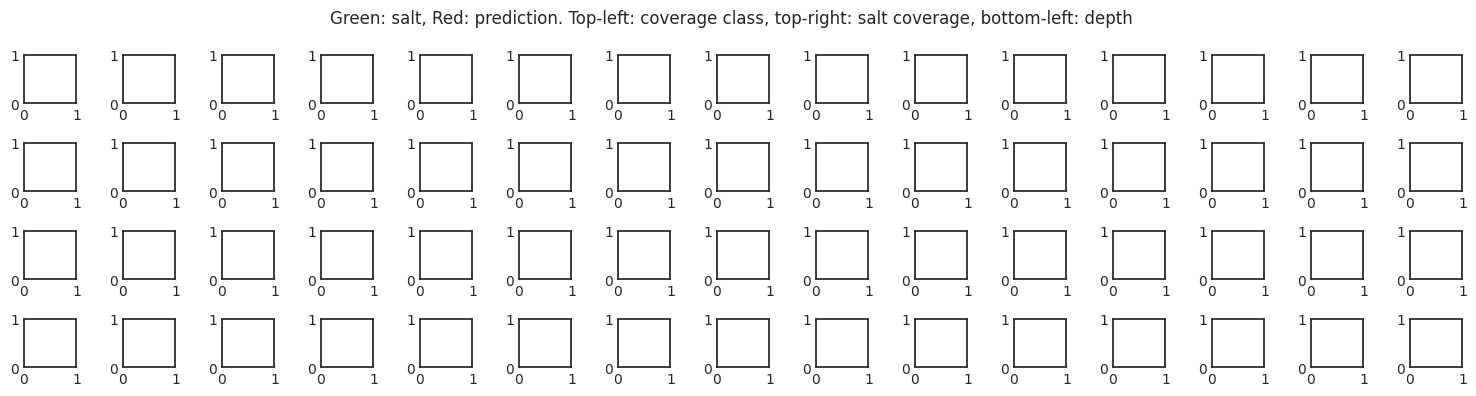

In [60]:
import numpy as np
import matplotlib.pyplot as plt

max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)

fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx, 'images']  # Assuming 'images' is the column name for images
    mask = train_df.loc[idx, 'masks']   # Assuming 'masks' is the column name for masks
    pred = preds_valid[i]

    if mask is None or pred is None:
        continue  # Skip if mask or pred is None

    # Ensure mask and pred are numpy arrays and convert to float32 if necessary
    mask = mask.astype(np.float32)
    pred = pred.astype(np.float32)

    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(pred, alpha=0.3, cmap="OrRd")

    # Example text positions, adjust as needed
    ax.text(10, 10, f"Depth: {train_df.loc[idx, 'z']}", color="black")
    ax.text(img_size_ori - 10, 10, f"Coverage: {round(train_df.loc[idx, 'coverage'], 2)}", color="black", ha="right", va="top")
    ax.text(10, img_size_ori - 10, f"Coverage Class: {train_df.loc[idx, 'coverage_class']}", color="black", ha="left", va="top")

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Index: {idx}")  # Set title as per your requirement

plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")
plt.tight_layout()
plt.show()


In [66]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook # Make sure tqdm is imported

# ... (rest of your code)

def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in

    # Handle potential None values in labels
    if labels is None:
        return 0  # Or handle it in a way that makes sense for your use case

    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    ## Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union
# Precision helper function
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1   # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)

    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        # Handle potential None values before calling iou_metric
        if y_true_in[batch] is not None:
            value = iou_metric(y_true_in[batch], y_pred_in[batch])
            metric.append(value)
    return np.mean(metric)

# ... (rest of your code)

thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

<ipython-input-66-5cb01c92d9fc>:76: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])


  0%|          | 0/50 [00:00<?, ?it/s]

In [67]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

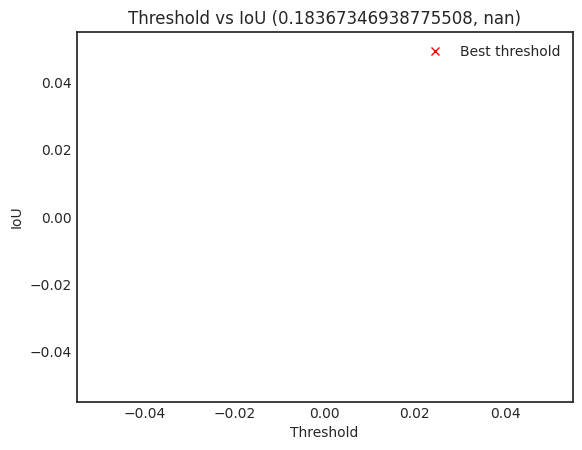

In [68]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

#problem 2

**Visualized Scaling Steps:**

I inspected the scaling methods to ensure they align with expected behavior, providing sanity checks for reliability and potential reuse by others.
Stratification by Salt Content:

Incorporated stratification based on varying levels of salt in the image data, enhancing data handling for better model training outcomes.
Y-Axis Image Flipping Augmentation:

Implemented image augmentation by horizontally flipping images along the y-axis, a technique verified and clarified through forum discussions.
Integration of Dropout for Enhanced Performance:

Introduced dropout regularization into the model architecture, resulting in noticeable performance improvements during testing and validation phases.


**Please Note** Mouting the Image folder to my google drive is taking alot of time. which is why you can see most of the boxes appears to be empty,if the images were mounted, everything would appear the way they should.